Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, September 22, 2017.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from sklearn.linear_model import LinearRegression

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

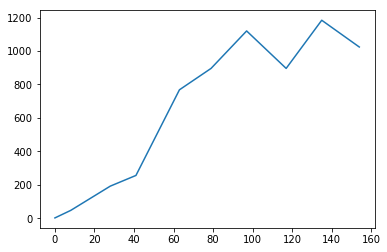

In [2]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

Question 1.1
We can rewrite the logistic model to:

$$\frac{d(log\frac{p}{1-p})}{dt} = r, \text{where } p = \frac{N}{K}$$

So we can $logistic(p)=rt+logistic(p_0), p = \frac{N}{K} \text{and } p_0 = \frac{N_0}{K}$. Finally the solution comes as:

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

The cost function $J$ can be expressed as:
$$J = \frac{1}{2m} (\hat{N_t} - N_t)^2 \sim (\hat{N_t} - N_t)^2$$


The first model using least square error gives K = 1033.515, r = 0.118


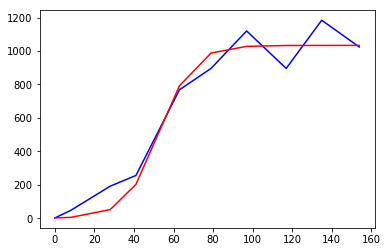

In [3]:
# code for question 1.1
def costfunc(theta):
    K = theta[0]
    r = theta[1]
    N_0 = 2
    t = days
    N_t = beetles
    N_t_hat = 1.0*N_0*K/(N_0+(K-N_0)*np.exp(-r*t))
    return np.sum((N_t_hat - N_t)**2)

days = np.array(days)
beetles = np.array(beetles)
# optimization
from scipy.optimize import minimize
# intialized guess

theta = [500, 0.5]
res = minimize(costfunc, theta, method='Nelder-Mead', tol = 1e-6)
K = res.x[0]
r = res.x[1]
print("The first model using least square error gives K = %.3f, r = %.3f" % (K, r))
N_0 = 2
model1 = 1.0*N_0*K/(N_0+(K-N_0)*np.exp(-r*days))

# plot vs the original
plt.plot(days, beetles, c = 'b')
plt.plot(days, model1, c = 'r')

Question 1.2 The assumptions:

$$ log(N_t) \sim N(f(t), \sigma^2)$$
Get the log-likelihood for each data point based on the normal model and add them up to minimize. Since we need to provide estimates of standard errors and correlation between them, let's bootstrap the 10-point dataset for 1000 times and obtain $K_i$ and $r_i$ in each loop. Finally, calculate each strandard error and their correlation.

In [4]:
# code for question 1.2
from scipy.stats import norm

def loglikelihood(theta):
    K = theta[0]
    r = theta[1]
    var = theta[2]
    t = new_days
    x = new_beetles
    N_0 = 2
    # will use minimize, multiply by -1 instead
    return -1.0*np.sum(norm.logpdf(np.log(x),loc=np.log(1.0*N_0*K/(N_0+(K-N_0)*np.exp(-r*t))),scale=var))

# intialize at each loop
n = 1000
K_para = np.zeros(n)
r_para = np.zeros(n)
var_para = np.zeros(n)
new_days = np.zeros(days.shape)
new_beetles = np.zeros(beetles.shape)

for i in range(n):
    index = np.random.choice(len(days), len(days))
    new_days = np.take(days, index)
    new_beetles = np.take(beetles, index)
    theta = [500, 0.5, np.var(np.log(new_beetles))]
    res = minimize(loglikelihood, theta, method='Nelder-Mead', tol = 1e-6)
    K_para[i] = res.x[0]
    r_para[i] = res.x[1]
    var_para[i] = res.x[2]

print("The standard error of K is %.3f." % np.var(K_para))
print("The standard error of r is %.3f." % np.var(r_para))
print("The standard error of var is %.3f." % np.var(var_para))
print("The correlation between K and r is %.3f." % np.corrcoef(K_para, r_para)[0,1])
print("The correlation between r and var is %.3f." % np.corrcoef(r_para, var_para)[0,1])
print("The correlation between var and K is %.3f." % np.corrcoef(var_para, K_para)[0,1])

C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1691: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:1691: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


The standard error of K is 32778.437.
The standard error of r is 0.017.
The standard error of var is 0.039.
The correlation between K and r is -0.577.
The correlation between r and var is 0.528.
The correlation between var and K is -0.856.


## Question 2

A. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 
1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

In [5]:
baseball = pd.read_table('../data/baseball.dat', sep='\s+')
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

def annealingfunc(cooling_schedule, neighbors= 1, color = 'r'):
    aic_values = []
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_best = aic(g, solution_vars, logsalary)
    aic_values.append(aic_best)
    for tau in cooling_schedule:

        # Random change # 0f neighborhood
        flips = np.random.choice(ncols, neighbors, replace = False)
        for flip in flips:
            solution_current[flip] = not solution_current[flip] 
        solution_vars = predictors[predictors.columns[solution_current]]
        g = LinearRegression().fit(X=solution_vars, y=logsalary)
        aic_step = aic(g, solution_vars, logsalary)
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            solution_current[flip] = not solution_current[flip]
            aic_values.append(aic_values[-1])
    # for comparison, add color argument
    plt.plot(aic_values, color)
    plt.xlim(0, len(aic_values))
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
                np.where(solution_best==True),
                np.where(aic_values==aic_best)[0][0]))
    plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, color + 'o')

Best AIC: -416.27478945580975
Best solution: (array([ 2,  7,  8,  9, 12, 13, 17, 19, 20, 21, 24, 25], dtype=int64),)
Discovered at iteration 251
Best AIC: -418.323309183033
Best solution: (array([ 2,  5,  7,  9, 11, 12, 13, 19, 20, 21, 24, 25], dtype=int64),)
Discovered at iteration 99
Best AIC: -419.5816254569727
Best solution: (array([ 1,  2,  7,  8,  9, 12, 13, 14, 15, 16, 23, 24, 25], dtype=int64),)
Discovered at iteration 354


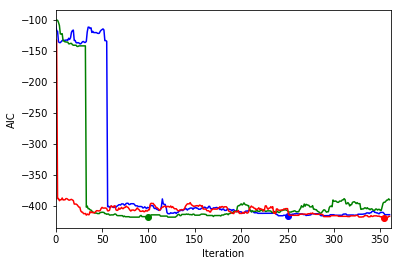

In [6]:
# Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).
tau_start = 10
# in class cases
cooling_schedule = [tau_start]*60 + [tau_start/2]*120 + [tau_start/10]*180
annealingfunc(cooling_schedule, color = 'b')
# flip the sequence
annealingfunc(cooling_schedule[::-1], color = 'g')
# try equal length
cooling_schedule = [tau_start]*120 + [tau_start/2]*120 + [tau_start/10]*120
annealingfunc(cooling_schedule, color = 'r')

Flipping the cooling schedule make the AIC values increase in last few iterations. So starting with high-value temperature is crucial. Probably choose smaller values as the iteration goes on. I prefer the original cooling schedule in our example case (blue curve).

C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in exp


Best AIC: -418.6118886471736
Best solution: (array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 23, 24], dtype=int64),)
Discovered at iteration 113
Best AIC: -418.6118886471736
Best solution: (array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 23, 24], dtype=int64),)
Discovered at iteration 93


C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars


Best AIC: -418.4319865070067
Best solution: (array([ 2,  5,  7,  9, 10, 11, 12, 13, 14, 15, 19, 21, 25], dtype=int64),)
Discovered at iteration 299


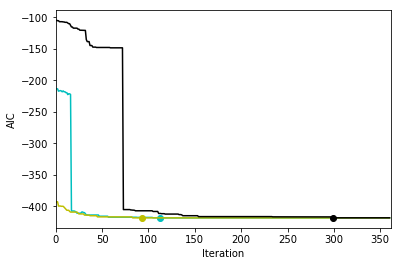

In [7]:
# try different ratio factors 0.9, 0.5, 0.1
cooling_schedule = [tau_start*0.9**i for i in range(360)]
annealingfunc(cooling_schedule, color = 'c')
cooling_schedule = [tau_start*0.5**i for i in range(360)]
annealingfunc(cooling_schedule, color = 'y')
cooling_schedule = [tau_start*0.1**i for i in range(360)]
annealingfunc(cooling_schedule, color = 'k')

It seems that we obtain the best and minimum AIC value for 0.9 and 0.5 ratio factor earlier than 0.1. I pefer use 0.9 or 0.8 because it makes the cooling schedule more smoothly than 0.5 and 0.1.

Best AIC: -412.584379230853
Best solution: (array([ 2,  5,  7,  8,  9, 10, 12, 13, 14, 15, 21, 22, 23, 26], dtype=int64),)
Discovered at iteration 48
Best AIC: -409.4457921888546
Best solution: (array([ 3,  5,  6,  7,  8,  9, 11, 12, 13, 17, 19, 20, 21, 26], dtype=int64),)
Discovered at iteration 169


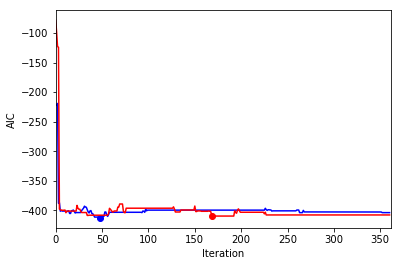

In [8]:
# Compare the effect of a proposal distribution that is discrete uniform 
# over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.
cooling_schedule = [tau_start*i/360 for i in range(360, 0, -1)]
annealingfunc(cooling_schedule, neighbors =2, color = 'b')
annealingfunc(cooling_schedule, neighbors =3, color = 'r')

Choosing 3-neighborhoods seems better than 2-neighborhoods.

B. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 
1. Compare the effects of using different mutation rates.  
2. Compare the effects of using different generation sizes.  
3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.

In [9]:
def calculate_fitness(aic_values):
    P = len(aic_values)
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

def geneticfunc(mutation_rate, pop_size, iterations, double_selection = False, color = 'b'):
    aic_best = []
    best_solution = []
    aic_history = []
    # Initialize genotype
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        if not double_selection:
            # Choose second parents randomly
            # in the example
            dads = np.random.choice(range(pop_size), size=int(pop_size/2))
        else:
            # Choose second parents according to fitness
            dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    
    plt.plot(aic_best, color)
    plt.xlim(0, iterations)
    plt.xlabel('Iteration')
    plt.ylabel('AIC')
    print("The best and minimum AIC is " +str(min(aic_best)))

The best and minimum AIC is -417.082309267
The best and minimum AIC is -416.471152363
The best and minimum AIC is -417.428228073
The best and minimum AIC is -420.081805182
The best and minimum AIC is -419.88576242


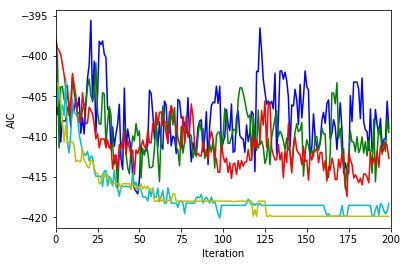

In [10]:
# Compare the effects of using different mutation rates.
mutation_rates = [0.2, 0.1, 0.05, 0.02, 0.005]
colors = ['b', 'g', 'r', 'c', 'y']
for i in range(len(colors)):
    geneticfunc(mutation_rates[i], pop_size = 20, iterations = 200, color = colors[i])

It seems that 0.02 is better than other mutation_rates.

The best and minimum AIC is -419.849357552
The best and minimum AIC is -420.947211437
The best and minimum AIC is -420.081805182
The best and minimum AIC is -420.081805182
The best and minimum AIC is -418.611888647


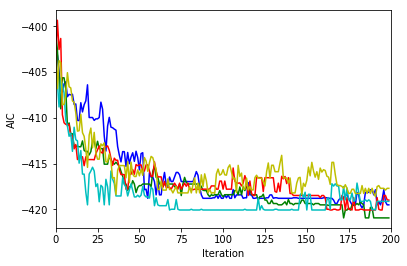

In [11]:
# Compare the effects of using different generation sizes.
generation_sizes = [10, 20, 30, 40, 50]
colors = ['b', 'g', 'r', 'c', 'y']
for i in range(len(colors)):
    geneticfunc(mutation_rate = 0.02, pop_size = 20, iterations = 200, color = colors[i])

As the generation size grows (for example, 50), we obtained the best and minimum AIC.

In [ ]:
# Instead of the selection mechanism used in the class example, 
# try using independent selection of both parents with probabilities proportional to their fitness.
geneticfunc(mutation_rate = 0.02, pop_size = 20, iterations = 200, double_selection = False, color = 'b')
geneticfunc(mutation_rate = 0.02, pop_size = 20, iterations = 200, double_selection = True, color = 'r')

Use 0.02 as mutation rate, 20 as generation size. The blue curve represents our original case in the example while we choose both parents according to the fitness and show the AIC tendency in the red curve. Without comparing the AIC values (very close), the blue curve seems more gradually decreasing to the minimum while the red curve is fast dropping down. Maybe I will prefer the blue curve.

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). I will award 5 bonus points to the best solution!

In [2]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('../data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

In [ ]:
import doctest
from itertools import permutations


def distance(point1, point2):
    """
    Returns the Euclidean distance of two points in the Cartesian Plane.

    >>> distance([3,4],[0,0])
    5.0
    >>> distance([3,6],[10,6])
    7.0
    """
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) ** 0.5


def total_distance(points):
    """
    Returns the length of the path passing throught
    all the points in the given order.

    >>> total_distance([[1,2],[4,6]])
    5.0
    >>> total_distance([[3,6],[7,6],[12,6]])
    9.0
    """
    return sum([distance(point, points[index + 1]) for index, point in enumerate(points[:-1])])


def travelling_salesman(points, start=None):
    """
    Finds the shortest route to visit all the cities by bruteforce.
    Time complexity is O(N!), so never use on long lists.

    >>> travelling_salesman([[0,0],[10,0],[6,0]])
    ([0, 0], [6, 0], [10, 0])
    >>> travelling_salesman([[0,0],[6,0],[2,3],[3,7],[0.5,9],[3,5],[9,1]])
    ([0, 0], [6, 0], [9, 1], [2, 3], [3, 5], [3, 7], [0.5, 9])
    """
    if start is None:
        start = points[0]
    return min([perm for perm in permutations(points) if perm[0] == start], key=total_distance)


def optimized_travelling_salesman(points, start=None):
    """
    As solving the problem in the brute force way is too slow,
    this function implements a simple heuristic: always
    go to the nearest city.

    Even if this algoritmh is extremely simple, it works pretty well
    giving a solution only about 25% longer than the optimal one (cit. Wikipedia),
    and runs very fast in O(N^2) time complexity.

    >>> optimized_travelling_salesman([[i,j] for i in range(5) for j in range(5)])
    [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4], [1, 3], [1, 2], [1, 1], [1, 0], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 4], [3, 3], [3, 2], [3, 1], [3, 0], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]
    >>> optimized_travelling_salesman([[0,0],[10,0],[6,0]])
    [[0, 0], [6, 0], [10, 0]]
    """
    if start is None:
        start = points[0]
    must_visit = points
    path = [start]
    must_visit.remove(start)
    while must_visit:
        nearest = min(must_visit, key=lambda x: distance(path[-1], x))
        path.append(nearest)
        must_visit.remove(nearest)
    return path


def main():
    doctest.testmod()
    points = [[0, 0], [1, 5.7], [2, 3], [3, 7],
              [0.5, 9], [3, 5], [9, 1], [10, 5]]
    print("""The minimum distance to visit all the following points: {}
starting at {} is {}.

The optimized algoritmh yields a path long {}.""".format(
        tuple(points),
        points[0],
        total_distance(travelling_salesman(points)),
        total_distance(optimized_travelling_salesman(points))))


if __name__ == "__main__":
    main()

In [24]:
np.random.choice(range(1,25), size = 24, replace = False )

array([ 6, 16, 17, 14,  9,  1, 23, 11,  8, 24, 13, 10, 22, 18, 12, 19,  5,
        3,  7, 21,  4,  2, 15, 20])

In [11]:
# Write your answer here
np.array(cities)

array([[  6.06733333e+01,   2.81972222e+00],
       [  5.10663889e+01,   3.88888889e-02],
       [  4.85044444e+01,  -1.45583333e+00],
       [  4.43027778e+01,  -2.52972222e+00],
       [  6.00250000e+01,  -3.10194444e+00],
       [  3.85430556e+01,  -3.71722222e+00],
       [  4.28019444e+01,  -5.08916667e+00],
       [  3.52094444e+01,  -5.79500000e+00],
       [  3.48630556e+01,  -7.11500000e+00],
       [  3.48811111e+01,  -8.05388889e+00],
       [  6.39038889e+01,  -8.76194444e+00],
       [  3.57352778e+01,  -9.66583333e+00],
       [  6.78100000e+01,  -9.97472222e+00],
       [  4.83602778e+01,  -1.02127778e+01],
       [  3.85108333e+01,  -1.29711111e+01],
       [  5.60966667e+01,  -1.55961111e+01],
       [  4.79297222e+01,  -1.57797222e+01],
       [  4.92538889e+01,  -1.66786111e+01],
       [  4.39377778e+01,  -1.99208333e+01],
       [  4.03377778e+01,  -2.03194444e+01],
       [  5.46463889e+01,  -2.04427778e+01],
       [  4.32075000e+01,  -2.29027778e+01],
       [  

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

In [ ]:
import os
import glob
import pandas as pd

# three paths
path1 =r'/Users/ruiwang/source/bios_8366/data/ebola/guinea_data'
path2 =r'/Users/ruiwang/source/bios_8366/data/ebola/liberia_data'
path3 =r'/Users/ruiwang/source/bios_8366/data/ebola/sl_data'

# add up
allFiles = []
for path in [path1, path2, path3]:
    allFiles += glob.glob(path + "/*.csv")

ebola = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)

ebola = pd.concat(list_)



In [ ]:
# rearrange the columns
col = ebola.columns.tolist()
for x in ['Date', 'Description', 'Totals']:
    col.remove(x)
col = ['Date', 'Description', 'Totals'] + col
ebola = ebola[col].fillna(0)
ebola = ebola[(ebola['Description'] == 'New cases of confirmed') & (ebola['Description'] == 'New deaths registered today')]